In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import networkx as nx
import itertools as it
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [224]:
DIM = 1

NN = 512
Lp = -1.0
irec = 66
Delta = 0.333333
NTS = 8


NDISC = 1.0

rand.seed(irec)

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net2d = nw_data['network'] 

net = network.convertToFlowNetwork(net2d)  

NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]



##################################################

L = np.copy(net.L)

pos = np.array([0.5*net2d.L[0], 0.5*net2d.L[1]])
s = network.closestEdge(net2d, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)


# pos = np.array([0.65*net2d.L[0], 0.65*net2d.L[1]])
# b = network.closestEdge(net2d, pos)[0]

# onodesi[0].append(edgei[b])
# onodesj[0].append(edgej[b])
# ostrain_bonds[0].append(b)


# inodesi[0].append(edgei[b])
# inodesj[0].append(edgej[b])
# istrain_bonds[0].append(b)
    
edge = range(net.NE)

rand.shuffle(edge)

for i in range(NTS):
    b = edge.pop()

    onodesi[0].append(edgei[b])
    onodesj[0].append(edgej[b])
    ostrain_bonds[0].append(b)

######################################################


isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)

# istrain[0].append(0.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(Delta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
#     pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
#     meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])
    
#     meas[t].setLambda(1, [0, 1])

oDelta = [Delta,Delta,-Delta,Delta, -Delta, Delta, -Delta, Delta]

obj_func = mns.CyIneqRatioChangeObjFunc(NTS, net.NE, 
                                        np.zeros(NTS, float), oDelta, np.sign(oDelta),
                                       relative=False, change=False)    


# obj_func = mns.CyEqRatioChangeObjFunc(2, net.NE, 
#                                         np.zeros(2, float), [1, 0.5],
#                                        relative=False, change=False, accuracy = 0.1)    



 

K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds
tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

[ 0.00366187  0.00451593  0.0482258  -0.00315278  0.00080749 -0.0006756
 -0.00862824 -0.00353865]
Initial objective function: 0.45887041027
Removing 0 / 1418.0 / 1418 bonds would create zero modes...
{'disc': 0.0, 'bond': 716}
0.450821441238 [array([ 0.00273901,  0.00270601,  0.01998705, -0.0023354 ,  0.00087865,
       -0.00058226, -0.00193007, -0.002082  ])]
0 Objective function: 0.450821441238 Change: -0.00804896903168 Percent: -1.75408325565 %
Removing 0 / 1417.0 / 1418 bonds would create zero modes...
{'disc': 0.0, 'bond': 689}
0.446624950218 [array([ 0.00181936,  0.00193186,  0.00935888, -0.00125256,  0.00034106,
       -0.00035838, -0.00242605, -0.00125472])]
1 Objective function: 0.446624950218 Change: -0.0041964910207 Percent: -0.930854355367 %
Removing 0 / 1416.0 / 1418 bonds would create zero modes...
{'disc': 0.0, 'bond': 708}
0.441202599039 [array([  6.77127575e-04,   1.91896092e-03,  -1.92044464e-03,
        -1.96080147e-05,  -5.48205987e-04,   1.35376654e-04,
        -5.

In [225]:
#Set initial response ratio



tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)
  
tuner.solver.setIntStrengths(K_max * K_disc)
meas_init = tuner.solver.solveMeas()

print meas_init

obj_func.setRatioInit(meas_init)

move_list = []
for b in range(net.NE):
    if data['K_disc'][b] == 0.0:
        move_list.append({'bond': b, 'disc': 1.0})
    else:
        move_list.append({'bond': b, 'disc': 0.0})
        
up_list = []
for move in move_list:
    up = talgs.Update()
    up.setStretchMod(1, [move['bond']], [K_max[move['bond']] * move['disc'] / NDISC])
    up_list.append(up.getCyUpdate())

    
tuner.solver.setIntStrengths(K_max * data['K_disc'])

meas_final = tuner.solver.solveMeas()
print meas_final

tuner.solver.prepareUpdateList(up_list)

zm_edges = []
cviol_edges = []
cviol_obj = []


for i, move in enumerate(move_list):     
                    
        bond = move['bond']
        disc = move['disc']

        bi = net.edgei[bond]
        bj = net.edgej[bond]

        (condition, m) = tuner.solver.solveMeasUpdate(i)
        
        if condition < 0.0:
            zm_edges.append(bond)                 
        else:
            obj = tuner.obj_func.objFunc(np.concatenate(m))
            if obj > data['obj_func']:
                cviol_edges.append(bond)
                cviol_obj.append(obj)

                
print zm_edges
print cviol_edges

[ 0.00366187  0.00451593  0.0482258  -0.00315278  0.00080749 -0.0006756
 -0.00862824 -0.00353865]
[ 0.33340316  0.59513322 -0.43675997  0.41379138 -0.33380691  0.33437936
 -0.40792937  0.3339372 ]
[1116, 1197]
[0, 9, 10, 21, 28, 36, 51, 61, 63, 70, 73, 81, 91, 102, 103, 123, 124, 135, 142, 258, 275, 307, 317, 318, 321, 322, 327, 329, 465, 494, 500, 505, 509, 510, 512, 514, 515, 517, 526, 527, 529, 532, 536, 537, 538, 539, 542, 543, 544, 547, 549, 550, 551, 552, 554, 556, 563, 564, 566, 567, 569, 570, 572, 575, 577, 579, 581, 582, 583, 586, 588, 589, 590, 591, 595, 596, 598, 601, 602, 604, 605, 606, 607, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 630, 631, 635, 638, 640, 641, 642, 644, 645, 648, 649, 650, 651, 652, 653, 654, 656, 657, 658, 659, 660, 661, 663, 665, 666, 668, 669, 670, 673, 678, 679, 680, 682, 683, 689, 691, 692, 693, 697, 698, 699, 700, 704, 705, 707, 708, 709, 711, 712, 713, 714, 716, 718, 719, 720, 721, 722, 723, 725, 726, 727, 728, 729, 731,

In [226]:
nodes_to_edge = {}
for i in range(net.NE):
    nodes_to_edge[tuple(sorted((net.edgei[i], net.edgej[i])))] = i


G = nx.Graph()
G.add_nodes_from(range(net.NN))
G.add_edges_from(zip(net.edgei, net.edgej))

# nx.draw(G, node_size=4)
# plt.show()

def angle(ni, nj):
    posi = net2d.node_pos[2*ni:2*ni+2]
    posj = net2d.node_pos[2*nj:2*nj+2]
    bvec = posj - posi
    bvec -= np.rint(bvec / net2d.L) * net2d.L
    bvec /= la.norm(bvec)
        
    theta = np.arctan2(bvec[1], bvec[0])
    
    return theta

DG = G.to_directed()
unvisited = set(DG.edges())

facets_to_nodes = []

cedge = unvisited.pop()
facet = [cedge[0], cedge[1]]

# for i in range(10):
while len(unvisited) > 0:

    ci = cedge[0]
    cj = cedge[1]
    ctheta = angle(ci, cj) + np.pi 
        
#     print "Current Facet:", facet
#     print "Current Edge:", cedge
    
        
    neighbors = []
    nangles = []
    for neigh in DG.neighbors(cj):
        if (cj, neigh) not in unvisited:
            continue
        
        ntheta = angle(cj, neigh) 
        
        dtheta = ctheta - ntheta
        dtheta -= np.floor(dtheta / (2*np.pi)) * 2*np.pi
        
        if neigh == ci:
            dtheta += 2*np.pi
                
        neighbors.append(neigh)
        nangles.append(dtheta)
        
    cedge = (cj, neighbors[np.argmin(nangles)])
    
#     print "Next Edge", cedge
    
    unvisited.discard(cedge)
        
    if facet[0] == cedge[1]:
        
#         print "Found new facet:", facet
        
        facets_to_nodes.append(np.copy(facet))
         
        if len(unvisited) > 0:
            cedge = unvisited.pop()
            facet = [cedge[0], cedge[1]]
    else:
        facet.append(cedge[1])                

print "Number Facets:", len(facets_to_nodes)

nodes_to_edges = {}
for i in range(net.NE):
    nodes_to_edges[tuple(sorted((net.edgei[i], net.edgej[i])))] = i


    
edges_to_facets = {tuple(sorted(edge)): [] for edge in G.edges()}
facets_to_edges = [[] for fi in range(len(facets_to_nodes))]

for fi, facet in enumerate(facets_to_nodes):
    for i in range(len(facet)):
        ni = facet[i]
        nj = facet[(i+1) % len(facet)]
        
        edge = tuple(sorted((ni, nj)))
        
        edges_to_facets[edge].append(fi)
                
        facets_to_edges[fi].append(nodes_to_edges[edge])
        
dual_NN = len(facets_to_nodes) 
dual_G = nx.Graph()
dual_G.add_nodes_from(range(dual_NN))
for key in edges_to_facets:
    dual_G.add_edge(*edges_to_facets[key])

Number Facets: 906


6.2412481855e-15 0.444443555556


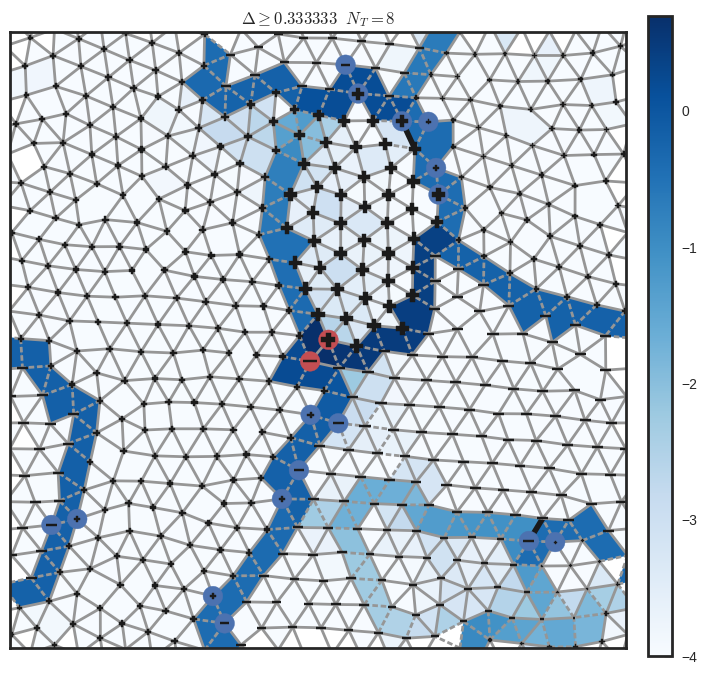

In [227]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

styles = {}    
center = 0.5 * np.ones(DIM, float)


palette = it.cycle(sns.color_palette("deep"))

patches = []
colors = ['white' for i in range(dual_NN)]
for fi, facet in enumerate(facets_to_nodes):
    corners = np.zeros([len(facet), 2], float)
    
    posi = net2d.node_pos[2*facet[0]:2*facet[0]+2] / net2d.L
    corners[0] = posi - np.floor(posi) - center
    
    
    for j in range(1,len(facet)):
        posj = net2d.node_pos[2*facet[j]:2*facet[j]+2] / net2d.L
        
        bvec = posj - posi
        bvec -= np.rint(bvec)
        
        corners[j] = posi - np.floor(posi) - center + bvec
        
        posj = posi
        
    patches.append(mpatches.Polygon(corners))
    
for edge in removed:
    for fi in edges_to_facets[tuple(sorted((net.edgei[edge], net.edgej[edge])))]:
        colors[fi] = 'c'

shear = np.zeros(len(facets_to_edges), float)
for fi in range(len(facets_to_edges)):
    
    gamma = 0.0
    
    for i in facets_to_edges[fi]:
        dispi = disp[DIM*net.edgei[i]:DIM*net.edgei[i]+DIM] 
        dispj = disp[DIM*net.edgej[i]:DIM*net.edgej[i]+DIM]
        
        gamma += np.abs(dispj - dispi)
        
        
    shear[fi] = gamma
    
norm = mcolors.Normalize(vmin=-4, vmax=np.log(np.max(shear)))
cmap = mpl.cm.Blues
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
for fi in range(len(facets_to_edges)):
    if shear[fi] > 1e-8:
        colors[fi] = smap.to_rgba(np.log(shear[fi]))
    else:
        colors[fi] = 'w'
    
pc = mc.PatchCollection(patches, color=colors, zorder=-1)
# pc.set_array(100*np.random.rand(len(patches)))
ax1.add_collection(pc)
     

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

for edge in zm_edges:
    styles[edge]['color'] = 'k'
    styles[edge]['lw'] = 4.0

print np.min(cviol_obj), np.max(cviol_obj)

    
# norm = mcolors.Normalize(vmin=-8, vmax=np.max(np.log10(cviol_obj)))
# cmap = mpl.cm.viridis
# smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    
# for i, edge in enumerate(cviol_edges):
#     styles[edge]['lw'] = 4.0
#     styles[edge]['color'] = smap.to_rgba(np.log10(cviol_obj[i]))
# #     styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net2d, styles=styles, alpha = 1.0)
    
    

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles)

styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles, marker='P')

styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles, marker='_')

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1.set_title(r'$\Delta \geq {0}$  $N_T = {1}$'.format(Delta, NTS))

cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

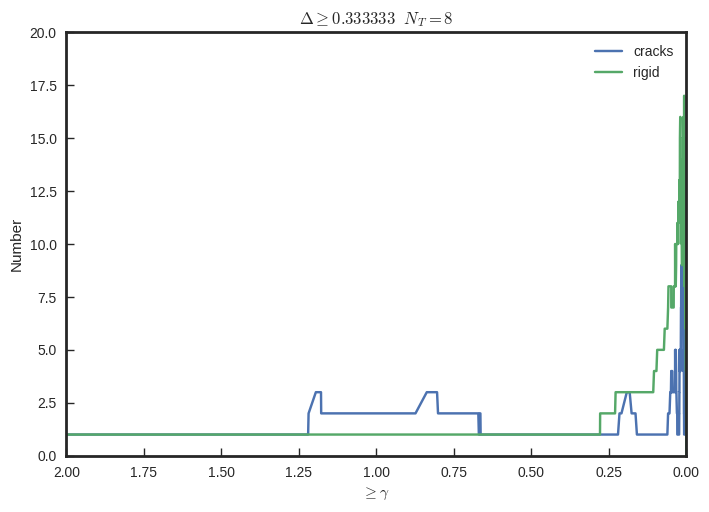

In [228]:
# print np.sort(shear)[::-1]
# print np.argsort(shear)[::-1]

persist_G = nx.Graph()
anti_persist_G = dual_G.copy()

face_sort = np.argsort(shear)[::-1]

unique_vals = np.unique(np.around(shear, 8))[::-1]

bins = {}
for i in unique_vals:
    bins[i] = np.where(np.around(shear, 8) == i)[0]
    
n_cracks = []
n_rigid = []

for i in unique_vals:
    
    for fi in bins[i]:

        persist_G.add_node(fi)
        anti_persist_G.remove_node(fi)

        for ni in dual_G.neighbors(fi):
            if persist_G.has_node(ni):
                persist_G.add_edge(fi, ni)
            
    
#     print i
#     print "Number of Cracks:", nx.number_connected_components(persist_G)
#     print "Number of Rigid Regions:", nx.number_connected_components(anti_persist_G)
        
    n_cracks.append(nx.number_connected_components(persist_G)) 
    n_rigid.append(nx.number_connected_components(anti_persist_G))
        
#     if i % 1 != 0:
#         continue
            
#     fig = plt.figure(figsize=(8,8))
#     ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)
    
#     norm = mcolors.Normalize(vmin=-4, vmax=np.log(np.max(shear)))
#     cmap = mpl.cm.Blues
#     smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

#     for fi in range(len(facets_to_edges)):
#         if persist_G.has_node(fi):
#             colors[fi] = smap.to_rgba(np.log(shear[fi]))
#         else:
#             colors[fi] = 'w'

#     pc = mc.PatchCollection(patches, color=colors, zorder=-1)
#     ax1.add_collection(pc)
    
#     styles = {edge: {} for edge in range(net.NE)}
#     for edge in removed:
#         styles[edge]['ls'] = (0.0, (2.0,1.0))
    
#     nplot.show_network(ax1, net2d, styles=styles, alpha = 1.0)

#     styles = {}
#     for i in inodesi:
#         styles[i] = {}
#         styles[i]['color'] = 'r'
#     for i in inodesj:
#         styles[i] = {}
#         styles[i]['color'] = 'r'

#     for i in onodesi:
#         styles[i] = {}
#         styles[i]['color'] = 'b'
#     for i in onodesj:
#         styles[i] = {}
#         styles[i]['color'] = 'b'

#     nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles)

#     styles = {}
#     for node in range(net.NN):

#         if disp[node] > 0.0:
#             styles[node] = {}
#             styles[node]['size'] = 200*np.abs(disp[node])

#     nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles, marker='P')

#     styles = {}
#     for node in range(net.NN):

#         if disp[node] < 0.0:
#             styles[node] = {}
#             styles[node]['size'] = 200*np.abs(disp[node])

#     nplot.show_nodes(ax1, net2d, styles.keys(), styles=styles, marker='_')

#     ax1.get_xaxis().set_ticks([])
#     ax1.get_yaxis().set_ticks([])

#     ax1.set_title(r'$\Delta \geq {0}$  $N_T = {1}$'.format(Delta, NTS))

#     cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
#     cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
#                                     norm=norm,
#                                     orientation='vertical')

#     plt.show()


fig, ax = plt.subplots(1,1)
ax.plot(unique_vals, n_cracks, "-", label="cracks")
ax.plot(unique_vals, n_rigid, "-", label="rigid")

ax.legend()

ax.set_xlabel(r"$\geq\gamma$")
ax.set_ylabel(r"Number")
# ax.set_xscale('log')
ax.set_xlim(0, 2)
ax.set_ylim(0, 20)
ax.invert_xaxis()

ax.set_title(r'$\Delta \geq {0}$  $N_T = {1}$'.format(Delta, NTS))

plt.show()